# ADVI
### Automatic Differentiation Variational Inference

Author: https://github.com/deburky

This implementation of ADVI (Automatic Differentiation Variational Inference) uses a mean-field Gaussian variational family to approximate the posterior over model parameters.

* The `MeanFieldVariational` class defines the variational distribution with reparameterized sampling and log-probability evaluation.
* The `ADVI` class handles ELBO estimation and optimization using Monte Carlo samples and gradient descent.
* A helper function, `make_log_joint`, constructs the joint log-probability.

## Custom ADVI

Running ADVI...
[   0] Loss: 312.83
[ 100] Loss: 204.25
[ 200] Loss: 153.99
[ 300] Loss: 142.95
[ 400] Loss: 136.66
[ 500] Loss: 137.40
[ 600] Loss: 137.06
[ 700] Loss: 135.47
[ 800] Loss: 135.29
[ 900] Loss: 135.33


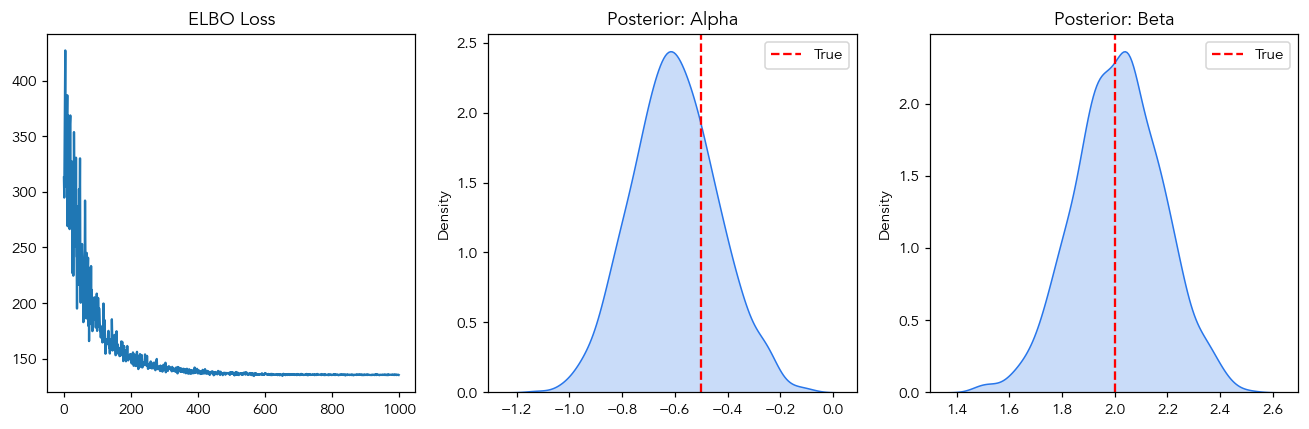

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.distributions as dist
import torch.nn as nn
import torch.optim as optim


# Variational family
class MeanFieldVariational(nn.Module):
    """Mean field variational distribution."""

    def __init__(self, dim):
        super().__init__()
        self.loc = nn.Parameter(torch.zeros(dim))
        self.log_scale = nn.Parameter(torch.full((dim,), -1.0))

    def sample(self, n_samples=1):
        eps = torch.randn(n_samples, len(self.loc))
        return self.loc + torch.exp(self.log_scale) * eps

    def log_prob(self, samples):
        q = dist.Normal(self.loc, torch.exp(self.log_scale))
        return q.log_prob(samples).sum(dim=-1)


# ADVI inference
class ADVI:
    """ADVI inference."""

    def __init__(self, log_joint, dim, lr=0.01, n_samples=20):
        self.log_joint = log_joint
        self.variational = MeanFieldVariational(dim)
        self.n_samples = n_samples
        self.optimizer = optim.Adam(self.variational.parameters(), lr=lr)

    def elbo(self):
        samples = self.variational.sample(self.n_samples)
        log_p = torch.stack([self.log_joint(s) for s in samples])
        log_q = self.variational.log_prob(samples)
        return (log_p - log_q).mean()

    def fit(self, steps=1000, snapshot_interval=10):
        self.snapshots = []
        losses = []
        for i in range(steps):
            self.optimizer.zero_grad()
            loss = -self.elbo()
            loss.backward()
            self.optimizer.step()
            losses.append(loss.item())

            # Save snapshot of variational mean
            if i % snapshot_interval == 0:
                self.snapshots.append(self.variational.loc.detach().clone())

            if i % 100 == 0:
                print(f"[{i:4d}] Loss: {loss.item():.2f}")
        return losses

    def sample_posterior(self, n=1000):
        with torch.no_grad():
            return self.variational.sample(n)


# Logistic regression model
class LogisticRegressionModel:
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def log_joint(self, params):
        alpha, beta = params
        logits = alpha + beta * self.x
        prior = dist.Normal(0, 1)
        log_prior = prior.log_prob(alpha) + prior.log_prob(beta)
        log_lik = dist.Bernoulli(logits=logits).log_prob(self.y).sum()
        return log_prior + log_lik

    @staticmethod
    def true_params():
        return [-0.5, 2.0]

    @staticmethod
    def param_names():
        return ["Alpha", "Beta"]

    @staticmethod
    def dim():
        return 2


# Data and training
np.random.seed(43)
n = 500
x_data = np.random.uniform(-3, 3, n)
true_alpha, true_beta = LogisticRegressionModel.true_params()
logits = true_alpha + true_beta * x_data
probs = 1 / (1 + np.exp(-logits))
y_data = np.random.binomial(1, probs)

model = LogisticRegressionModel(x_data, y_data)
advi = ADVI(model.log_joint, dim=model.dim(), n_samples=5)
print("Running ADVI...")
losses = advi.fit(steps=1000)
posterior_samples = advi.sample_posterior(n=1000)

# Set font to Avenir
plt.rcParams["font.family"] = "Avenir"


# Plotting
def plot_posterior(samples, true_vals, names):
    fig, ax = plt.subplots(1, len(true_vals) + 1, figsize=(12, 4), dpi=110)
    ax[0].plot(losses)
    ax[0].set_title("ELBO Loss")
    for i, name in enumerate(names):
        sns.kdeplot(samples[:, i].numpy(), ax=ax[i + 1], fill=True, color="#2876EA")
        ax[i + 1].axvline(true_vals[i], color="r", linestyle="--", label="True")
        ax[i + 1].set_title(f"Posterior: {name}")
        ax[i + 1].legend()
    plt.tight_layout()
    plt.show()


plot_posterior(posterior_samples, model.true_params(), model.param_names())

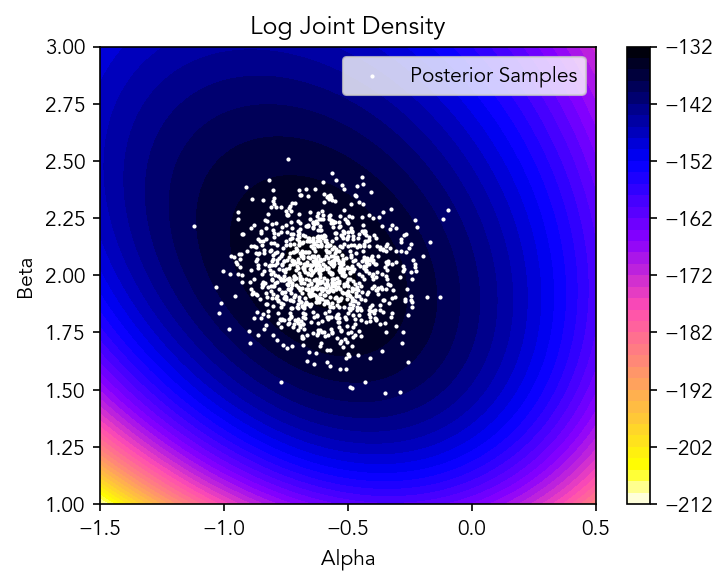

In [2]:
alpha_range = np.linspace(-1.5, 0.5, 100)
beta_range = np.linspace(1.0, 3.0, 100)
A, B = np.meshgrid(alpha_range, beta_range)

elbo_grid = np.zeros_like(A)

for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        params = torch.tensor([A[i, j], B[i, j]], dtype=torch.float32)
        elbo_grid[i, j] = model.log_joint(params).item()

plt.figure(figsize=(5, 4), dpi=150)
contour = plt.contourf(A, B, elbo_grid, levels=50, cmap="gnuplot2_r")
plt.colorbar(contour)
plt.xlabel("Alpha")
plt.ylabel("Beta")
plt.title("Log Joint Density")
plt.scatter(
    posterior_samples[:, 0],
    posterior_samples[:, 1],
    s=1,
    c="white",
    alpha=1.0,
    label="Posterior Samples",
)
plt.legend()
plt.tight_layout()
plt.show()

## PyMC ADVI

Output()

Finished [100%]: Average Loss = 135.42


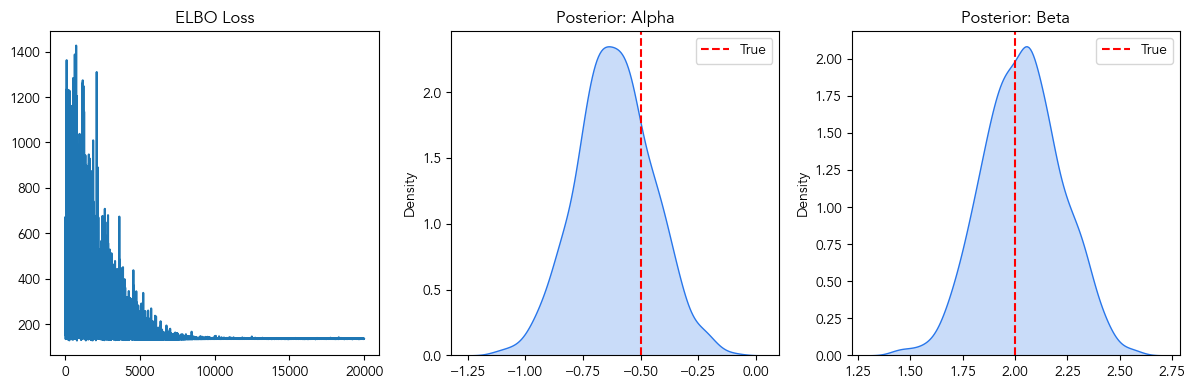

In [3]:
import itertools

import pymc as pm

# Simulate same data
np.random.seed(43)
n = 500
x_data = np.random.uniform(-3, 3, n)
true_alpha, true_beta = -0.5, 2.0
logits = true_alpha + true_beta * x_data
probs = 1 / (1 + np.exp(-logits))
y_data = np.random.binomial(1, probs)

# PyMC model
with pm.Model() as logistic_model:
    alpha = pm.Normal("Alpha", mu=0, sigma=1)
    beta = pm.Normal("Beta", mu=0, sigma=1)
    logits = alpha + beta * x_data
    pm.Bernoulli("y", logit_p=logits, observed=y_data)

    # Mean-field ADVI
    approx = pm.fit(method="advi", n=20_000)
    posterior_samples = approx.sample(1000)


def plot_posterior_pymc(trace, true_vals):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    for i, name in enumerate(["Alpha", "Beta"]):
        sns.kdeplot(
            trace.posterior[name].values.flatten(),
            ax=ax[i + 1],
            fill=True,
            color="#2876EA",
        )
        ax[i + 1].axvline(true_vals[i], color="r", linestyle="--", label="True")
        ax[i + 1].set_title(f"Posterior: {name}")
        ax[i + 1].legend()

    ax[0].plot(approx.hist)
    ax[0].set_title("ELBO Loss")

    plt.tight_layout()
    plt.show()


plot_posterior_pymc(posterior_samples, [-0.5, 2.0])

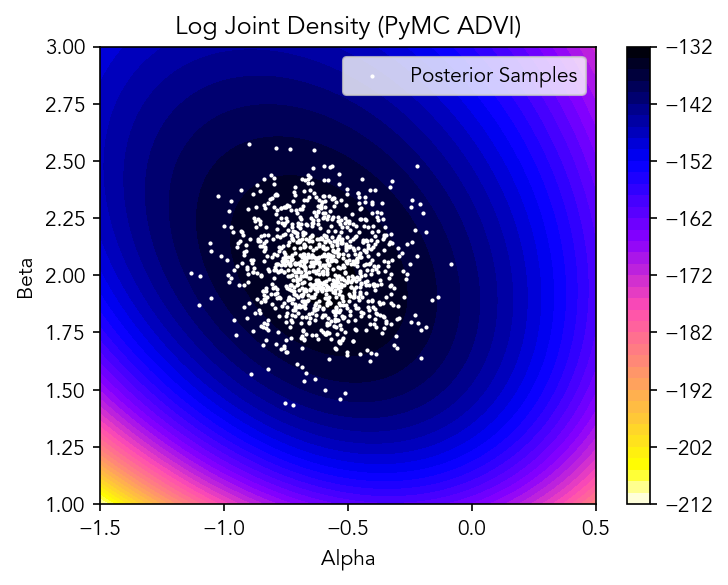

In [4]:
# Define grid over alpha and beta
alpha_range = np.linspace(-1.5, 0.5, 100)
beta_range = np.linspace(1.0, 3.0, 100)
A, B = np.meshgrid(alpha_range, beta_range)

log_joint_grid = np.zeros_like(A)


# Define log joint density function (same priors and likelihood as model)
def log_joint(alpha, beta, x_data, y_data):
    prior = dist.Normal(0, 1).log_prob(torch.tensor(alpha)) + dist.Normal(
        0, 1
    ).log_prob(torch.tensor(beta))
    logits = alpha + beta * torch.tensor(x_data, dtype=torch.float32)
    log_lik = (
        dist.Bernoulli(logits=logits)
        .log_prob(torch.tensor(y_data, dtype=torch.float32))
        .sum()
    )
    return (prior + log_lik).item()


# Compute log joint on the grid
for i, j in itertools.product(range(A.shape[0]), range(A.shape[1])):
    log_joint_grid[i, j] = log_joint(A[i, j], B[i, j], x_data, y_data)

# Extract posterior samples from InferenceData
alpha_samples = posterior_samples.posterior["Alpha"].values.flatten()
beta_samples = posterior_samples.posterior["Beta"].values.flatten()

# Plot
plt.figure(figsize=(5, 4), dpi=150)
contour = plt.contourf(A, B, log_joint_grid, levels=50, cmap="gnuplot2_r")
plt.colorbar(contour)
plt.xlabel("Alpha")
plt.ylabel("Beta")
plt.title("Log Joint Density (PyMC ADVI)")

plt.scatter(
    alpha_samples,
    beta_samples,
    s=1,
    c="white",
    alpha=1.0,
    label="Posterior Samples",
)

plt.legend()
plt.tight_layout()
plt.show()


## Real-world example

We show ADVI on a German FinTech dataset (939 companies, 17 subsegments, 1921-2021).

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("German_FinTechCompanies.csv")

# Create binary outcome
df["Target"] = df[["Insolvency", "Liquidation"]].max(axis=1)

# Encode groups
subsegment_encoder = LabelEncoder()
company_encoder = LabelEncoder()

df["subseg_id"] = subsegment_encoder.fit_transform(df["Subsegment"].fillna("Unknown"))
df["comp_id"] = company_encoder.fit_transform(df["Legal Name"].fillna("Unknown"))

n_subsegments = df["subseg_id"].nunique()
n_companies = df["comp_id"].nunique()

x_subseg = torch.tensor(df["subseg_id"].values, dtype=torch.long)
x_comp = torch.tensor(df["comp_id"].values, dtype=torch.long)
y = torch.tensor(df["Target"].values, dtype=torch.float32)

df["subseg_code"], uniques = pd.factorize(df["Subsegment"])
segment_name_map = {f"subseg_{i}": name for i, name in enumerate(uniques)}

In [6]:
class HierarchicalLogisticModel:
    def __init__(self, subseg_idx, comp_idx, y, n_subseg, n_comp):
        self.subseg_idx = subseg_idx
        self.comp_idx = comp_idx
        self.y = y
        self.n_subseg = n_subseg
        self.n_comp = n_comp

    def log_joint(self, params):
        # Unpack
        offset = 0
        alpha_global = params[offset]
        offset += 1
        subseg_effect = params[offset : offset + self.n_subseg]
        offset += self.n_subseg
        comp_effect = params[offset : offset + self.n_comp]
        offset += self.n_comp

        logits = (
            alpha_global + subseg_effect[self.subseg_idx] + comp_effect[self.comp_idx]
        )

        log_prior = dist.Normal(0, 1).log_prob(alpha_global)
        log_prior += dist.Normal(0, 1).log_prob(subseg_effect).sum()
        log_prior += dist.Normal(0, 1).log_prob(comp_effect).sum()

        log_lik = dist.Bernoulli(logits=logits).log_prob(self.y).sum()

        return log_prior + log_lik

    def dim(self):
        return 1 + self.n_subseg + self.n_comp

    def param_names(self):
        return (
            ["alpha_global"]
            + [f"subseg_{i}" for i in range(self.n_subseg)]
            + [f"comp_{i}" for i in range(self.n_comp)]
        )


model = HierarchicalLogisticModel(
    subseg_idx=x_subseg,
    comp_idx=x_comp,
    y=y,
    n_subseg=n_subsegments,
    n_comp=n_companies,
)

advi = ADVI(log_joint=model.log_joint, dim=model.dim(), n_samples=10)
losses = advi.fit(steps=1000)
posterior_samples = advi.sample_posterior(n=1000)

[   0] Loss: 1268.54
[ 100] Loss: 410.31
[ 200] Loss: 352.70
[ 300] Loss: 344.50
[ 400] Loss: 340.01
[ 500] Loss: 336.99
[ 600] Loss: 335.53
[ 700] Loss: 335.20
[ 800] Loss: 334.08
[ 900] Loss: 334.11


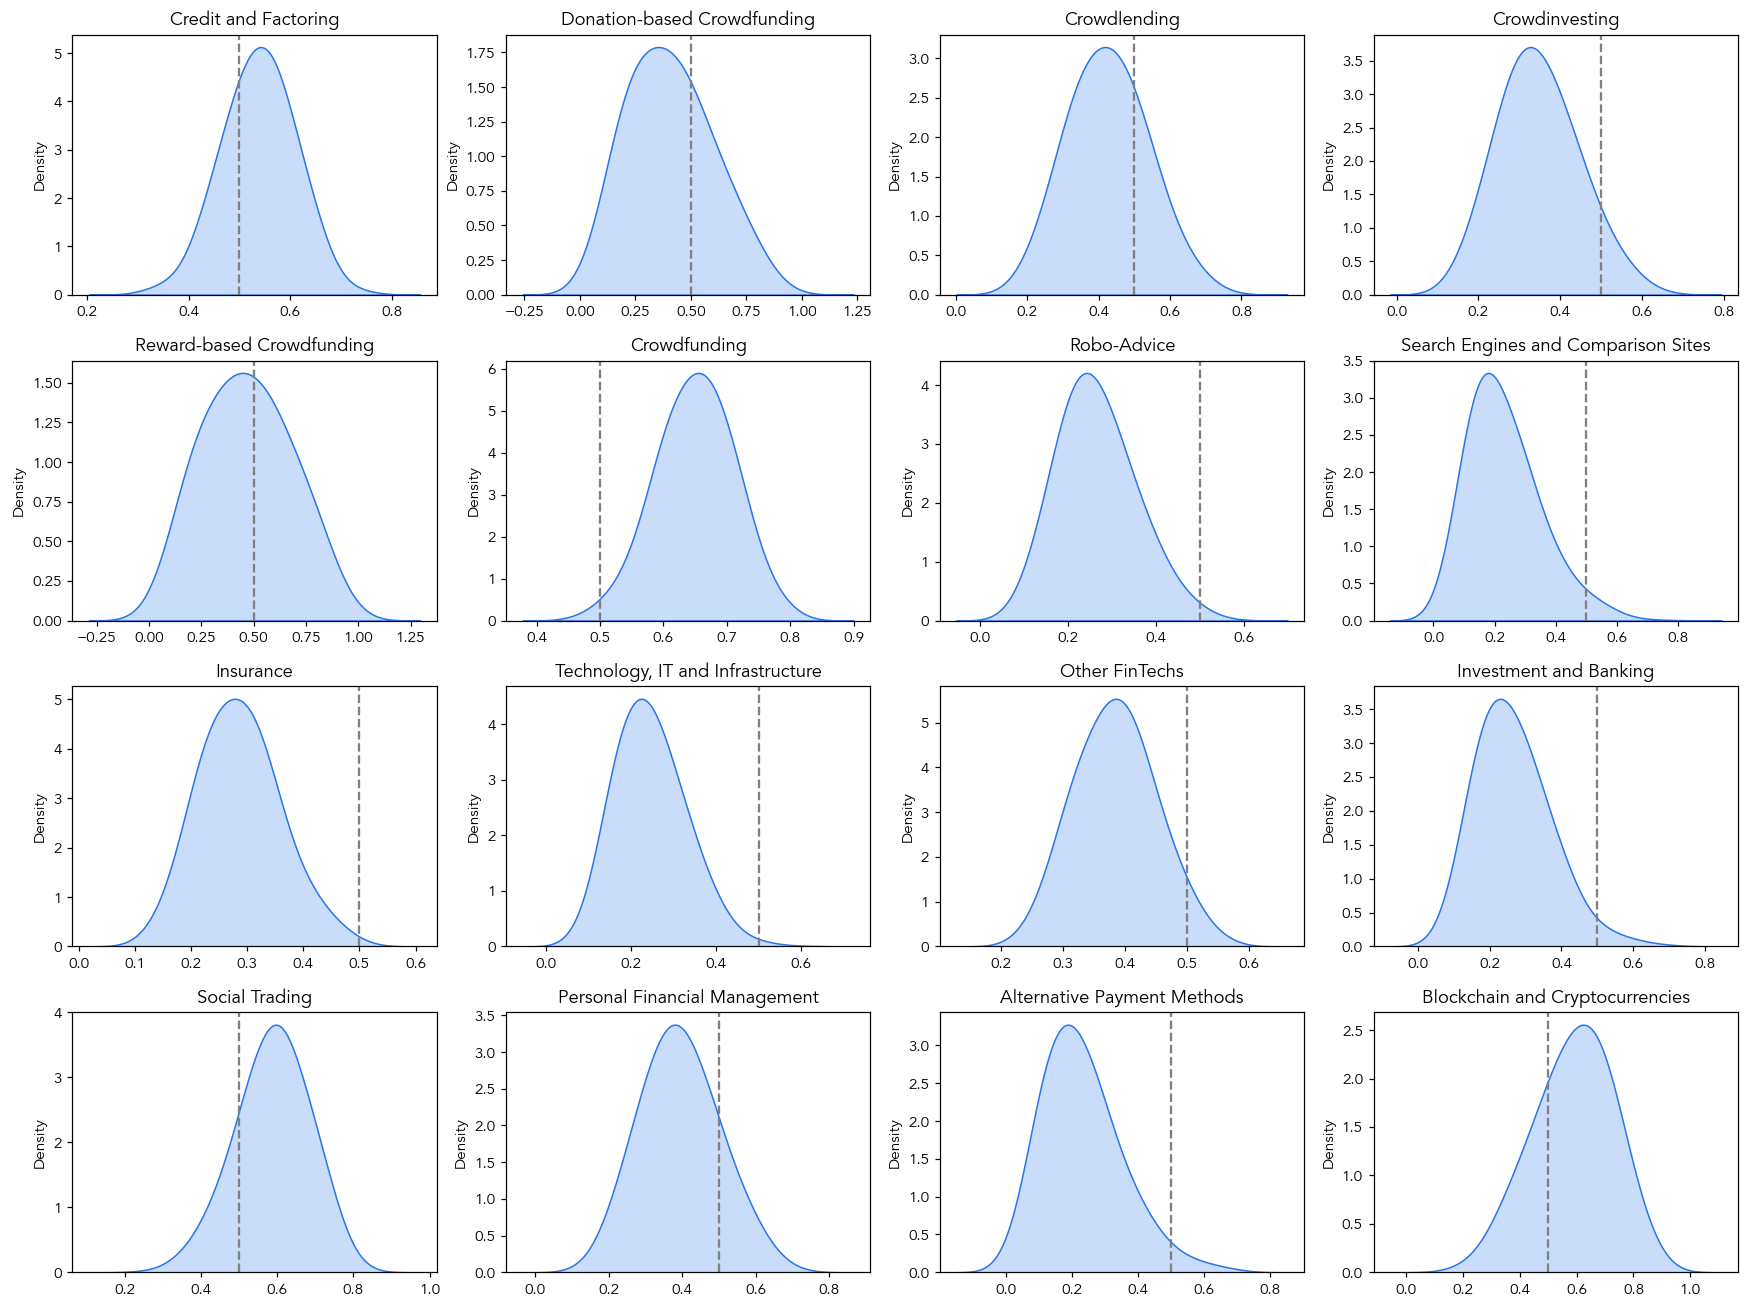

In [7]:
def plot_subsegment_grid(
    samples,
    param_names,
    prefix="subseg_",
    n_cols=4,
    max_plots=16,
    name_map=None,
    probability=True,
):
    import math

    subseg_indices = [
        i for i, name in enumerate(param_names) if name.startswith(prefix)
    ]
    subseg_labels = [param_names[i] for i in subseg_indices]

    if len(subseg_indices) > max_plots:
        subseg_indices = subseg_indices[:max_plots]
        subseg_labels = subseg_labels[:max_plots]

    n_plots = len(subseg_indices)
    n_rows = math.ceil(n_plots / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), dpi=110)
    axes = axes.flatten()

    for i, (idx, label) in enumerate(zip(subseg_indices, subseg_labels, strict=False)):
        values = samples[:, idx]
        if probability:
            values = torch.sigmoid(values)

        sns.kdeplot(values.numpy(), ax=axes[i], fill=True, color="#2876EA", bw_adjust=2)
        display_name = name_map.get(label, label) if name_map else label
        axes[i].set_title(display_name)
        axes[i].axvline(0.5 if probability else 0, color="gray", linestyle="--")

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


plot_subsegment_grid(
    posterior_samples,
    model.param_names(),
    prefix="subseg_",
    n_cols=4,
    max_plots=16,
    name_map=segment_name_map,
)

/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_11820/727980077.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap(cmap)(np.linspace(0, 1, n_plots))


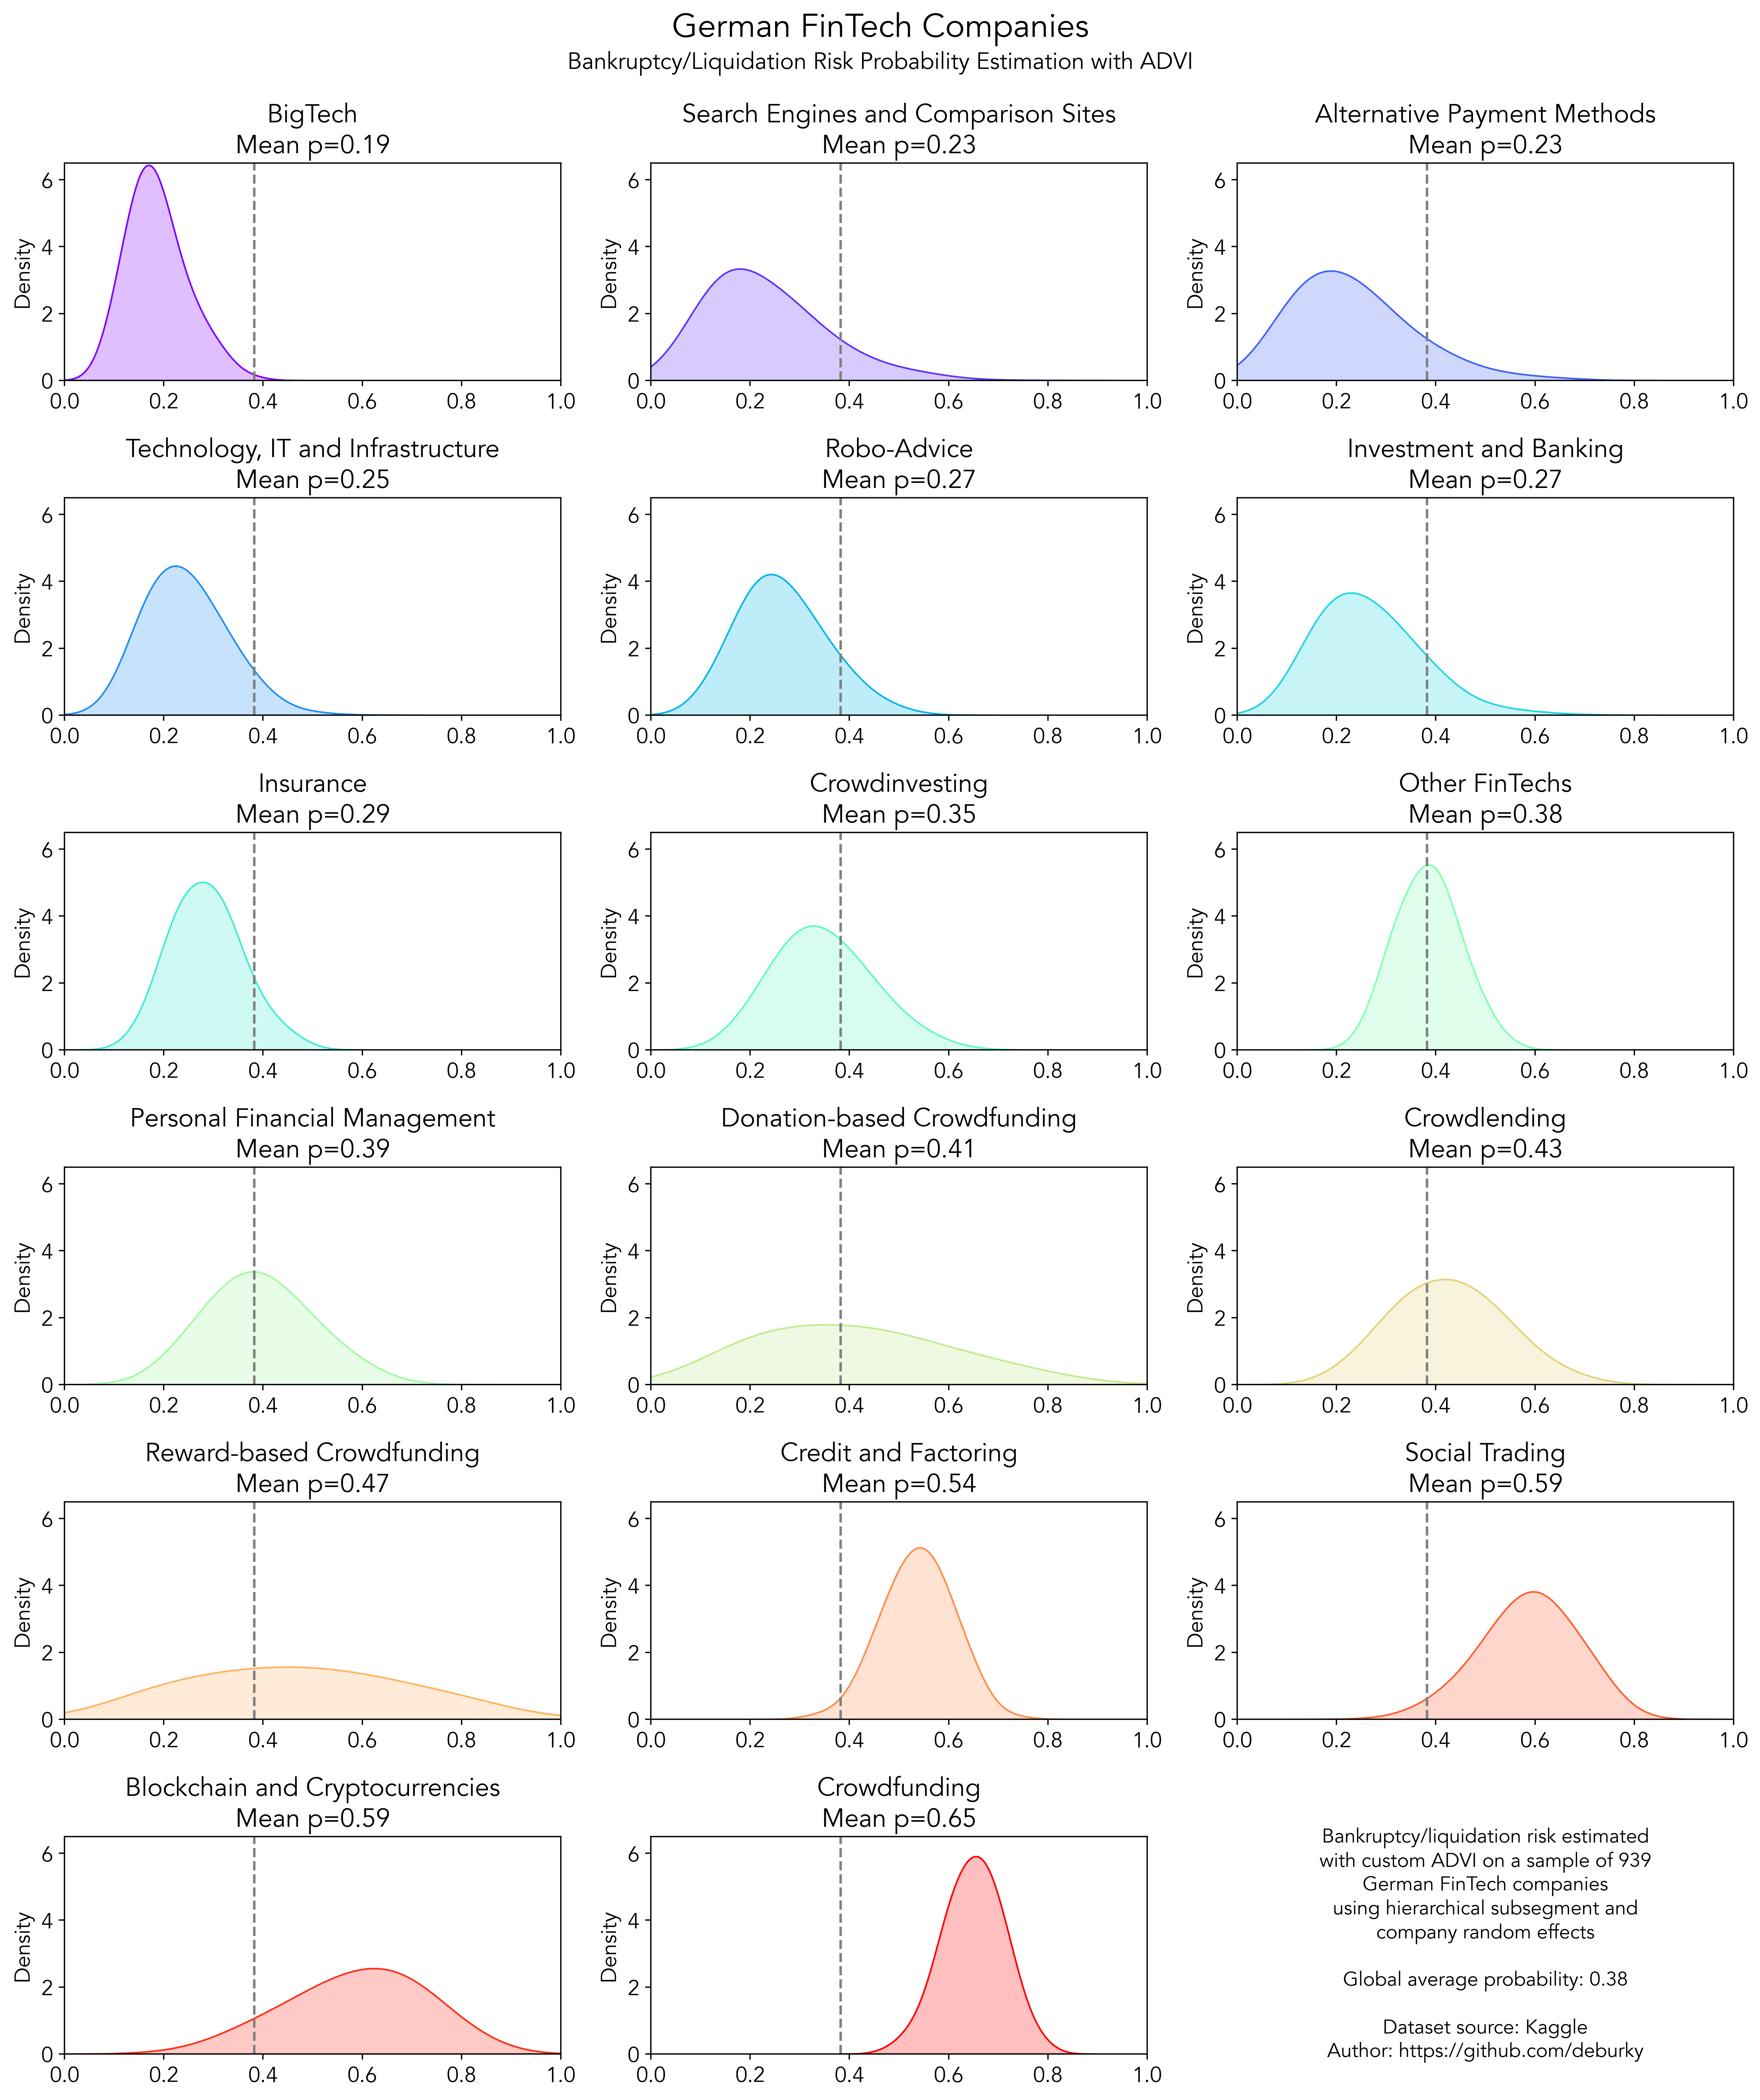

In [8]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

%config InlineBackend.figure_format = 'retina'


def plot_subsegment_grid(
    samples,
    param_names,
    prefix="subseg_",
    n_cols=4,
    max_plots=16,
    name_map=None,
    probability=True,
    cmap="rainbow",
):
    # Get indices and labels
    subseg_indices = [
        i for i, name in enumerate(param_names) if name.startswith(prefix)
    ]
    subseg_labels = [param_names[i] for i in subseg_indices]

    # Compute mean probabilities
    probs = [
        torch.sigmoid(samples[:, i]).mean().item()
        if probability
        else samples[:, i].mean().item()
        for i in subseg_indices
    ]

    # Global average p (for reference line)
    global_avg_p = (
        torch.sigmoid(samples[:, subseg_indices]).mean().item()
        if probability
        else samples[:, subseg_indices].mean().item()
    )

    # Sort by risk (low prob = risky → comes first)
    sorted_data = sorted(
        zip(probs, subseg_indices, subseg_labels, strict=False), key=lambda t: t[0]
    )
    if len(sorted_data) > max_plots:
        sorted_data = sorted_data[:max_plots]

    sorted_probs, sorted_indices, sorted_labels = zip(*sorted_data, strict=False)
    n_plots = len(sorted_indices)
    n_rows = math.ceil(n_plots / n_cols)

    # Colormap mapping
    colors = cm.get_cmap(cmap)(np.linspace(0, 1, n_plots))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3 * n_rows), dpi=200)
    axes = axes.flatten()

    for i, (idx, label, p_mean) in enumerate(
        zip(sorted_indices, sorted_labels, sorted_probs, strict=False)
    ):
        values = samples[:, idx]
        if probability:
            values = torch.sigmoid(values)

        sns.kdeplot(values.numpy(), ax=axes[i], fill=True, color=colors[i], bw_adjust=2)
        display_name = name_map.get(label, label) if name_map else label
        axes[i].set_title(f"{display_name}\nMean p={p_mean:.2f}")
        axes[i].axvline(
            global_avg_p if probability else 0, color="gray", linestyle="--"
        )
        axes[i].set_xlim(0, 1)
        axes[i].set_ylim(0, 6.5)

    # Add footer text to the next unused axis
    if i + 1 < len(axes):
        footer_ax = axes[i + 1]
        footer_ax.axis("off")
        footer_ax.text(
            0.5,
            0.5,
            "Bankruptcy/liquidation risk estimated\n"
            "with custom ADVI on a sample of 939\nGerman FinTech companies\n"
            "using hierarchical subsegment and\n"
            "company random effects"
            f"\n\nGlobal average probability: {global_avg_p:.2f}\n\n"
            "Dataset source: Kaggle\n"
            "Author: https://github.com/deburky",
            ha="center",
            va="center",
            fontsize=12,
        )

    # Turn off any remaining axes
    for j in range(i + 2, len(axes)):
        axes[j].axis("off")

    # Disable unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    fig.text(0.5, 1.02, "German FinTech Companies", ha="center", fontsize=20)
    fig.text(
        0.5,
        1.005,
        "Bankruptcy/Liquidation Risk Probability Estimation with ADVI",
        ha="center",
        fontsize=14,
    )
    # plt.tight_layout()
    fig.tight_layout(rect=[0, 0.05, 1, 1])  # [left, bottom, right, top]
    plt.show()


df["subseg_code"], uniques = pd.factorize(df["Subsegment"])
segment_name_map = {f"subseg_{i}": name for i, name in enumerate(uniques)}

# Set font to 14
plt.rcParams.update({"font.size": 13})

plot_subsegment_grid(
    posterior_samples,
    model.param_names(),
    prefix="subseg_",
    n_cols=3,
    max_plots=17,
    cmap="rainbow",
    name_map=segment_name_map,
    probability=True,
)